In [13]:
!pip install geopy

In [14]:
import requests
import networkx as net
import pandas as pd
from matplotlib import pylab
import matplotlib.pyplot as plt

import geopy.distance as geo

## Sabre API Example

In [15]:
endpoint = "https://api.test.sabre.com/v2/shop/flights/fares"

params = {
        "origin": "JFK",
        "destination": "LAX",
        "lengthofstay": "5",
        "pointofsalecountry": "US"
        }

# add auth header
headers = {}

#print requests.get(endpoint,params=params,headers=headers).json()

## Loading the Dataset

In [19]:
def clean_str(line):
    invalids = ['"', '\n']
    for n in invalids:
        line = line.replace(n, '')
        
    return line

def extract_data(file_loc, props):
    # Read in file
    file_obj = open(file_loc, "r",encoding="utf8")
    lines = file_obj.readlines()
    file_obj.close()
    

    #Takes the lines that were read in, does a split to create an array, then zips
    #with the props to create a 2d array, and then forms a dictionary from that 2d array,
    #and returns a list of those dictionaries.
    return list(map(lambda x: dict(zip(props, clean_str(x).split(","))), lines))

In [20]:
airport_props = [
        "airport_id",
        "name",
        "city",
        "country",
        "iata",
        "icao",
        "lat",
        "lon",
        "altitude",
        "timezone",
        "dst",
        "tz_database_time_zone",
        "type",
        "source"
]

route_props = [
        "airline",
        "airline_id",
        "source_airport",
        "source_airport_id",
        "destination_airport",
        "destination_airport_id",
        "codeshare",
        "stops",
        "equipment"
        ]

airlines_props = [
    "airline_id",
    "name",
    "alias",
    "iata",
    "icao",
    "callsign",
    "country",
    "active"
]

In [21]:
routes = extract_data("./data/routes.dat", route_props)
airports = extract_data("./data/airports.dat", airport_props)
airlines = extract_data('./data/airlines.dat',airlines_props)

In [22]:
airport_locations = {}

for airport in airports:
    airport_locations[airport['iata']] = (airport['lat'], airport['lon'])

In [77]:
routes

[{'airline': '2B',
  'airline_id': '410',
  'codeshare': '',
  'destination_airport': 'KZN',
  'destination_airport_id': '2990',
  'equipment': 'CR2',
  'source_airport': 'AER',
  'source_airport_id': '2965',
  'stops': '0'},
 {'airline': '2B',
  'airline_id': '410',
  'codeshare': '',
  'destination_airport': 'KZN',
  'destination_airport_id': '2990',
  'equipment': 'CR2',
  'source_airport': 'ASF',
  'source_airport_id': '2966',
  'stops': '0'},
 {'airline': '2B',
  'airline_id': '410',
  'codeshare': '',
  'destination_airport': 'MRV',
  'destination_airport_id': '2962',
  'equipment': 'CR2',
  'source_airport': 'ASF',
  'source_airport_id': '2966',
  'stops': '0'},
 {'airline': '2B',
  'airline_id': '410',
  'codeshare': '',
  'destination_airport': 'KZN',
  'destination_airport_id': '2990',
  'equipment': 'CR2',
  'source_airport': 'CEK',
  'source_airport_id': '2968',
  'stops': '0'},
 {'airline': '2B',
  'airline_id': '410',
  'codeshare': '',
  'destination_airport': 'OVB',
  '

## Analysis

In [23]:
routes_df = pd.DataFrame(routes)
airlines_df = pd.DataFrame(airlines)

In [24]:
routes_airline = routes_df.merge(airlines_df,left_on="airline_id",right_on="airline_id",how="inner")[['airline', 'airline_id', 'codeshare', 'destination_airport',
       'destination_airport_id', 'equipment', 'source_airport',
       'source_airport_id', 'stops','name','active']].to_dict(orient='records')

In [25]:
g=net.Graph()

In [26]:
for airport in airports:
    g.add_node(airport['iata'], name= airport['name'], city= airport['city'], timezone = airport['timezone'], lat = airport['lat'], lon = airport['lon'])

In [27]:
for route in routes_airline:
    if ((route['destination_airport'] in airport_locations.keys()) and 
        (route['source_airport'] in airport_locations.keys())):
            
        source_geo = airport_locations[route['source_airport']]
        destination_geo = airport_locations[route['destination_airport']]
        distance = geo.great_circle(source_geo, destination_geo).miles

        g.add_edge(route['source_airport'],route['destination_airport'], \
                   stops =route['stops'],equipment=route['equipment'], airline_id =route['airline_id'], 
                  name = route['name'], active =route['active'], distance=distance)

In [28]:
def trim_edges (g, variable, weight=1):
    g2= net.Graph()
    
    for f, to, edata in g.edges(data=True):
        if edata[variable] > weight:
            g2.add_edge(f,to,edata)
    return g2

In [29]:
trimmed_g = trim_edges(g, 'distance')

## Visualizations

In [30]:
def show_graph(graph):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = net.spring_layout(graph)
    net.draw_networkx_nodes(graph,pos)
    net.draw_networkx_edges(graph,pos)
    net.draw_networkx_labels(graph,pos)

    cut = 1.00
    plt.show()

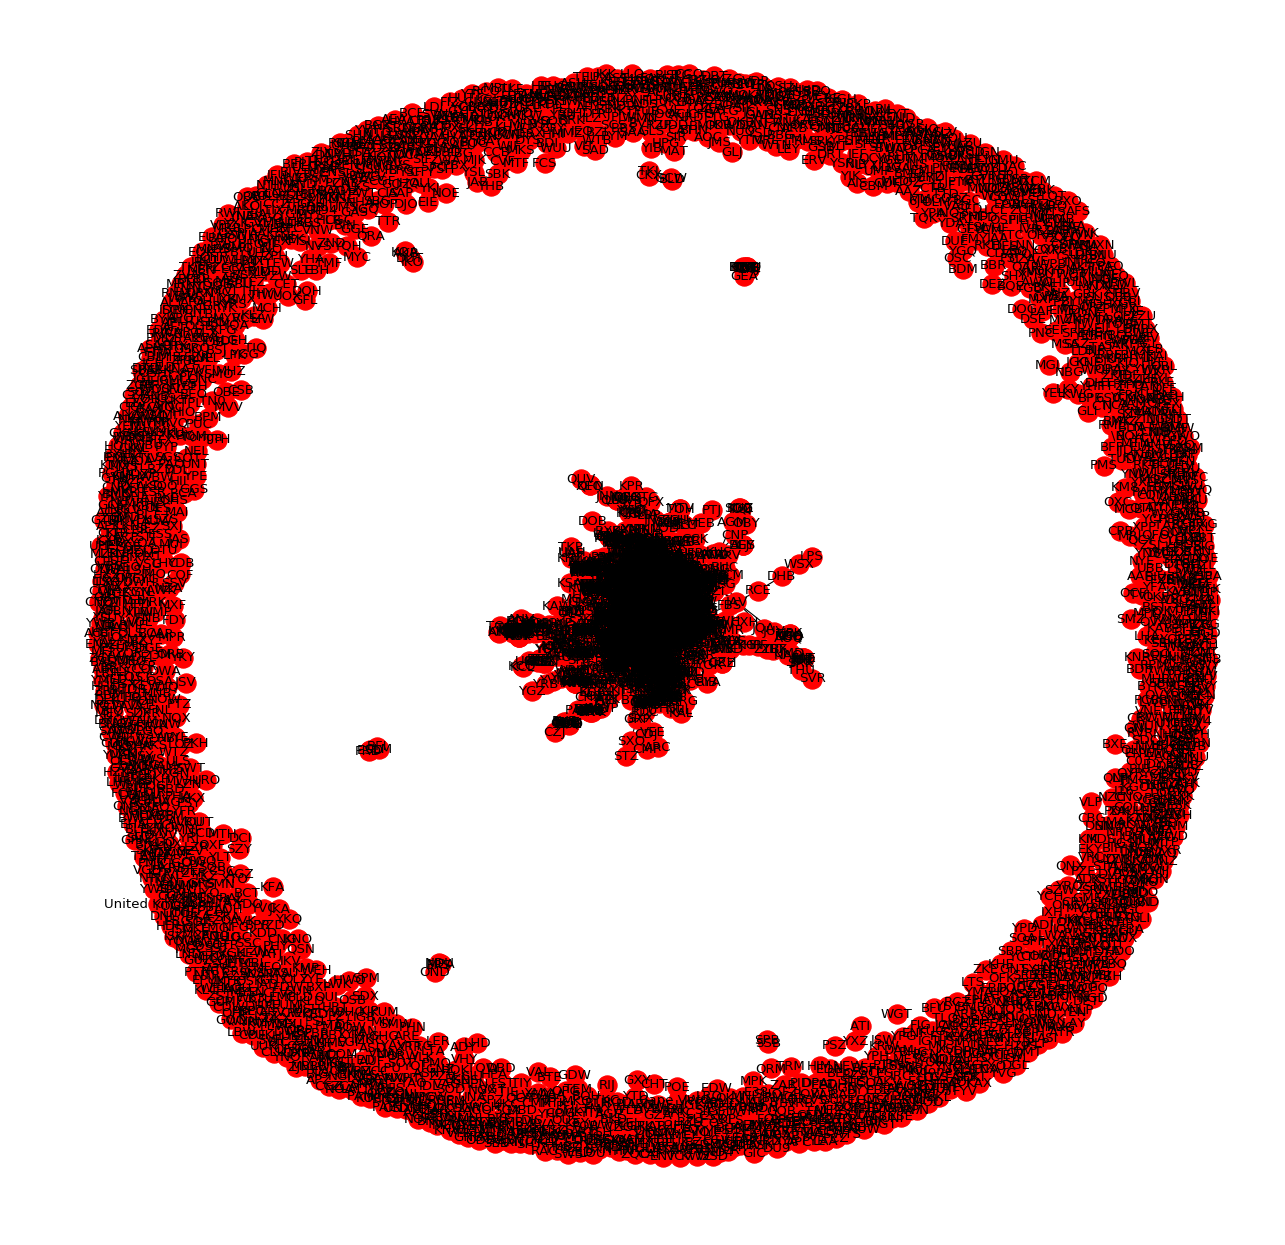

In [148]:
show_graph(g)

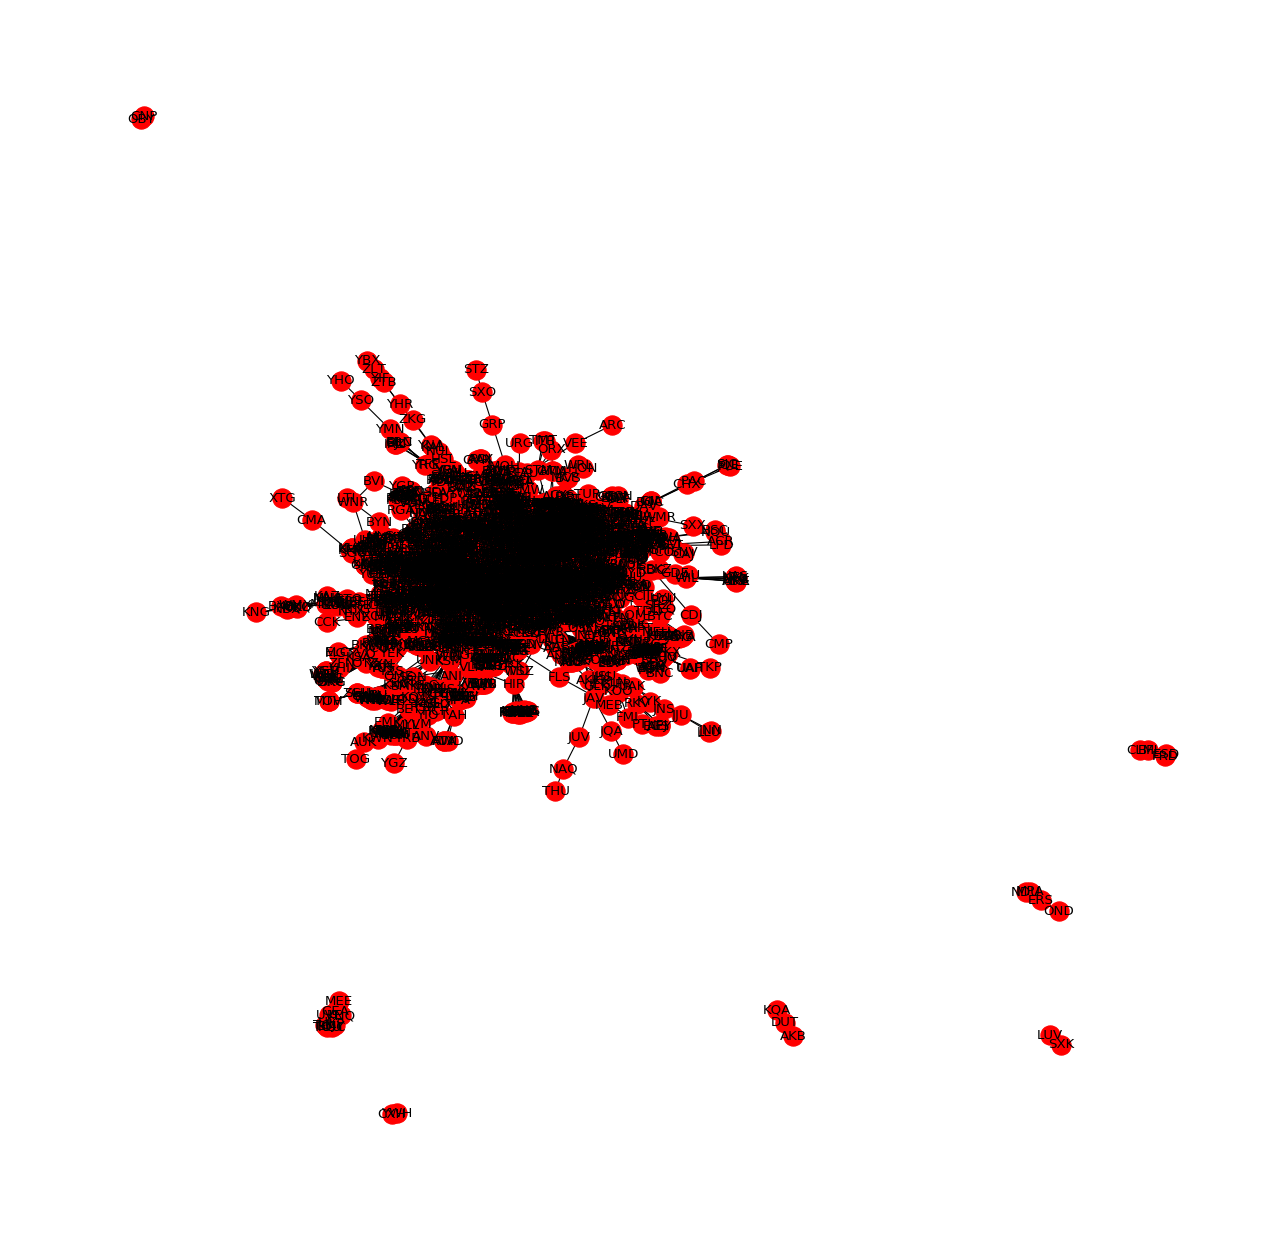

In [31]:
show_graph(trimmed_g)

In [41]:
def island_method(g, variable, iterations=5):
    """Using island method, we are limiting the number of nodes and clusters. 
    It calls trim edges with a threshold value. 
    
    Output of this function is the list of graphs with different threshold level.
    """
    weights= [edata[variable] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    print(mx)
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g,variable, threshold)] for threshold in range(mn,mx,step)]

In [75]:
def sorted_map(map1):
    """Defined a function to sort the dictionary"""
    ms = sorted(map1.items(), key =lambda k: -k[1])
    return ms

In [59]:
island_filter = island_method(g,'distance',10)


9995


In [63]:
sorted_map(net.get_edge_attributes(island_filter[8][1], name='distance'))

[[0, <networkx.classes.graph.Graph at 0xc078b00>],
 [999, <networkx.classes.graph.Graph at 0xc078518>],
 [1998, <networkx.classes.graph.Graph at 0xa0db7f0>],
 [2997, <networkx.classes.graph.Graph at 0x595be80>],
 [3996, <networkx.classes.graph.Graph at 0x4991940>],
 [4995, <networkx.classes.graph.Graph at 0xa8b60b8>],
 [5994, <networkx.classes.graph.Graph at 0xa8b6198>],
 [6993, <networkx.classes.graph.Graph at 0x29d1ba8>],
 [7992, <networkx.classes.graph.Graph at 0x4991ac8>],
 [8991, <networkx.classes.graph.Graph at 0x3ab37f0>],
 [9990, <networkx.classes.graph.Graph at 0x77ff198>]]